Correlation Matrix:
                sediment_thick       gwt    predom      vs30       dem  \
sediment_thick        1.000000 -0.216763  0.842865 -0.714979 -0.612316   
gwt                  -0.216763  1.000000 -0.253263  0.247926  0.106787   
predom                0.842865 -0.253263  1.000000 -0.740071 -0.632388   
vs30                 -0.714979  0.247926 -0.740071  1.000000  0.572196   
dem                  -0.612316  0.106787 -0.632388  0.572196  1.000000   
pga                   0.324652  0.247579  0.301166 -0.395725 -0.393711   
geo_form              0.279673 -0.152896  0.388118 -0.227223 -0.265748   
near_dis             -0.376476  0.024184 -0.446482  0.357406  0.317857   
near_dis_norm        -0.377148  0.024713 -0.447509  0.358859  0.318728   
near_dist            -0.422079  0.013253 -0.515818  0.432735  0.414401   
LIQ                   0.736590 -0.247550  0.807827 -0.638401 -0.564791   

                     pga  geo_form  near_dis  near_dis_norm  near_dist  \
sediment_thick  0

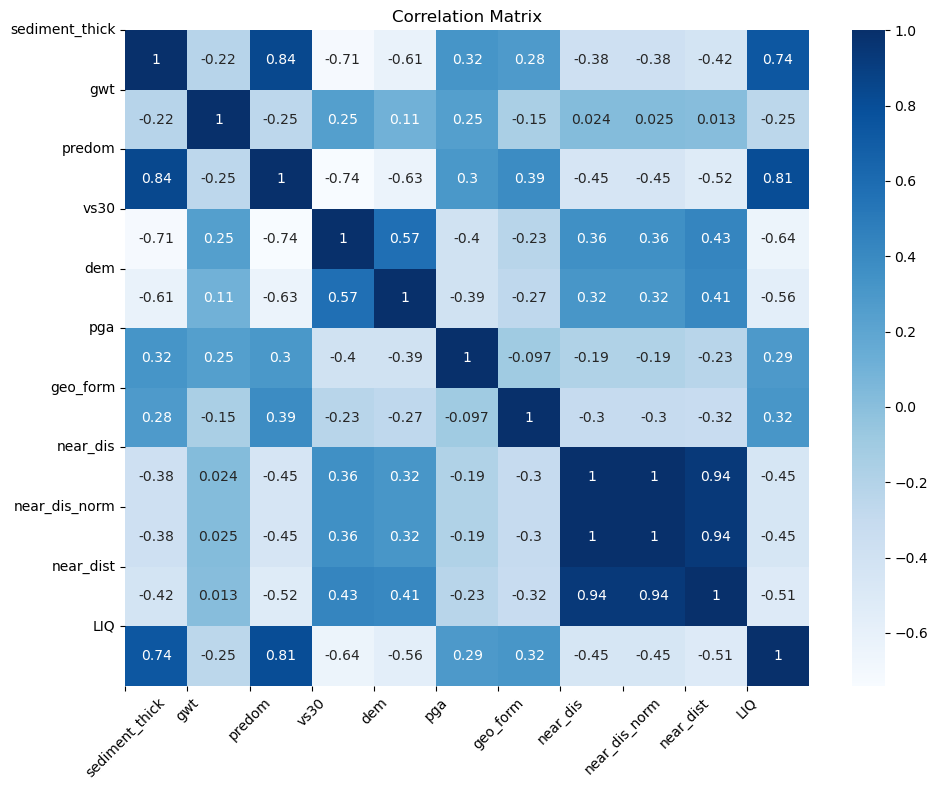

Variance Inflation Factor (VIF):
        VIF        features
0  2.692961        near_dis
1  8.584742  sediment_thick
2  9.325158          predom
3  8.550982            vs30
4  5.150100             pga
5  6.126440        geo_form
Feature Importance (Information Gain Ratio):
Feature 1: near_dis (importance: 0.187)
Feature 2: sediment_thick (importance: 0.303)
Feature 3: predom (importance: 0.395)
Feature 4: vs30 (importance: 0.242)
Feature 5: pga (importance: 0.135)
Feature 6: geo_form (importance: 0.346)


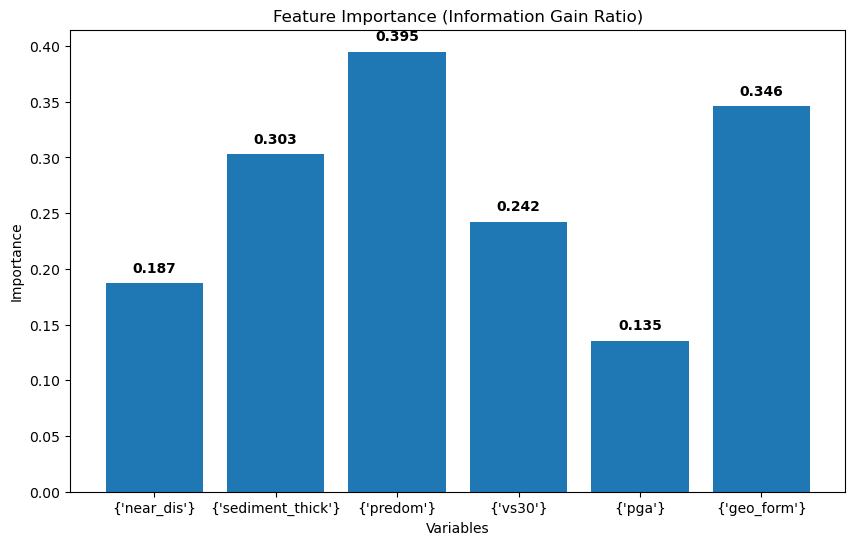

Epoch 1, Loss: 0.779
Epoch 2, Loss: 0.756
Epoch 3, Loss: 0.734
Epoch 4, Loss: 0.720
Epoch 5, Loss: 0.699
Epoch 6, Loss: 0.677
Epoch 7, Loss: 0.671
Epoch 8, Loss: 0.643
Epoch 9, Loss: 0.628
Epoch 10, Loss: 0.605
Epoch 11, Loss: 0.591
Epoch 12, Loss: 0.583
Epoch 13, Loss: 0.562
Epoch 14, Loss: 0.538
Epoch 15, Loss: 0.526
Epoch 16, Loss: 0.521
Epoch 17, Loss: 0.504
Epoch 18, Loss: 0.485
Epoch 19, Loss: 0.478
Epoch 20, Loss: 0.464
Epoch 21, Loss: 0.456
Epoch 22, Loss: 0.433
Epoch 23, Loss: 0.435
Epoch 24, Loss: 0.425
Epoch 25, Loss: 0.403
Epoch 26, Loss: 0.419
Epoch 27, Loss: 0.402
Epoch 28, Loss: 0.407
Epoch 29, Loss: 0.383
Epoch 30, Loss: 0.366
Epoch 31, Loss: 0.348
Epoch 32, Loss: 0.374
Epoch 33, Loss: 0.346
Epoch 34, Loss: 0.357
Epoch 35, Loss: 0.324
Epoch 36, Loss: 0.327
Epoch 37, Loss: 0.321
Epoch 38, Loss: 0.328
Epoch 39, Loss: 0.310
Epoch 40, Loss: 0.308
Epoch 41, Loss: 0.313
Epoch 42, Loss: 0.317
Epoch 43, Loss: 0.327
Epoch 44, Loss: 0.306
Epoch 45, Loss: 0.326
Epoch 46, Loss: 0.2

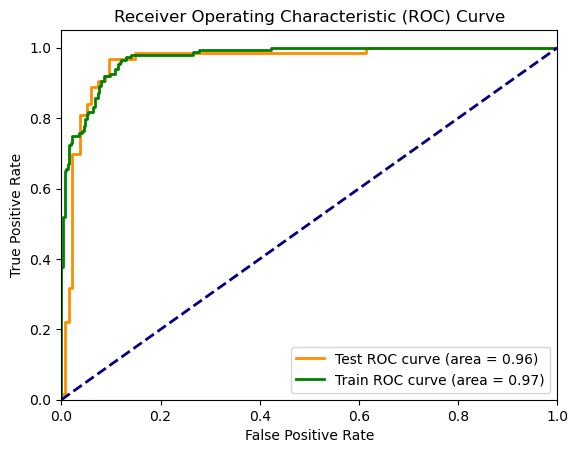

True Positive Rate: 0.873
False Positive Rate: 0.059
True Negative Rate: 0.941
False Negative Rate: 0.127


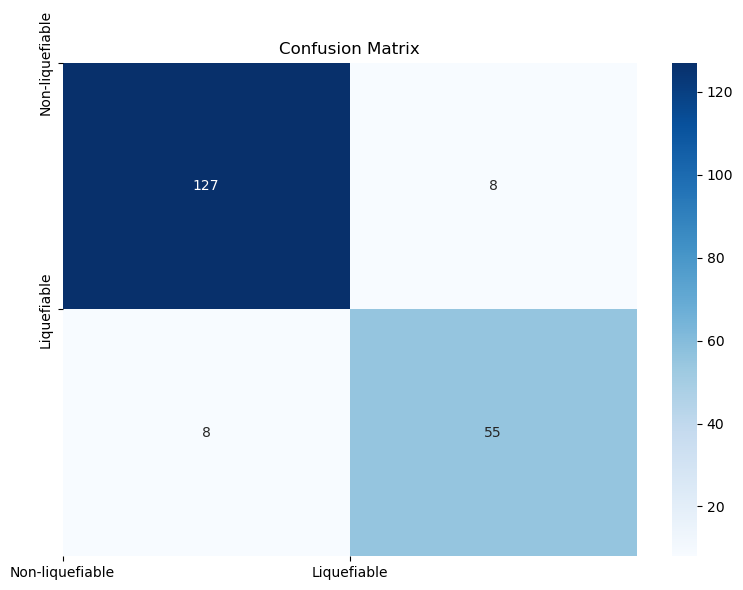

In [2]:
## MINIMUM ETA = 11 MINUTES ##

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

# Set a random seed for reproducibility
torch.manual_seed(36)
np.random.seed(36)

# Load the dataset
data = pd.read_csv("C:\\Users\\LE\\Downloads\\THESIS\\Program\\CSV\\GRID_LABEL_KTMBASIN_classify_v2.2.csv")

# Calculate correlation of the dataset
correlation_matrix = data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Draw heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
#plt.imshow(correlation_matrix, interpolation='nearest')
plt.title("Correlation Matrix")
#plt.colorbar()
tick_marks = [i for i in range(len(data.columns))]
plt.xticks(tick_marks, data.columns, rotation=45)
plt.yticks(tick_marks, data.columns)
plt.tight_layout()
plt.show()

# Preprocess the data
X = data[["near_dis", "sediment_thick", "predom", "vs30", "pga", "geo_form"]]
y = data["LIQ"]

# Calculate VIF
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
print("Variance Inflation Factor (VIF):")
print(vif)

# Create a custom dataset class
class LiquefactionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X.iloc[idx, :].values
        y = self.y.iloc[idx]
        return {
            'x': torch.tensor(x, dtype=torch.float),
            'y': torch.tensor(y, dtype=torch.long)
        }

# Create data loaders

max_depth = 10  # maximum depth of the decision tree
n_estimators = 100  # number of decision trees in the ensemble
random_state = 36  # random state for reproducibility
test_size = 0.3  # test size for testing data

# Hyperparameters
hidden_size = 64
learning_rate = 0.0001
epochs = 300
batch_size = 64

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) 
 
dataset_train = LiquefactionDataset(X_train, y_train) 
dataset_test = LiquefactionDataset(X_test, y_test)
 
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False)

# Define the ANN model
class ANNModel(nn.Module):
    def __init__(self, hidden_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(6, hidden_size)  # input layer (6) -> hidden layer (128)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)  # hidden layer (128) -> hidden layer (64)
        self.fc3 = nn.Linear(hidden_size//2, 2)  # hidden layer (64) -> output layer (2)

    def forward(self, x):
        batch_size = x.size(0)  # get the batch size
        x = x.view(batch_size, 6)  # reshape the input tensor
        x = torch.relu(self.fc1(x))  # activation function for hidden layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ANNModel(hidden_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Calculate feature importance using Information Gain Ratio
information_gain_ratio = mutual_info_classif(X_train, y_train)
print("Feature Importance (Information Gain Ratio):")
for i, importance in enumerate(information_gain_ratio):
    print(f"Feature {i+1}: {X.columns[i]} (importance: {importance:.3f})")

# Draw bar chart for feature importance using Information Gain Ratio
plt.figure(figsize=(10, 6))
plt.bar(range(len(information_gain_ratio)), information_gain_ratio, align="center")
plt.xticks(range(len(information_gain_ratio)), [{X.columns[i]} for i in range(len(information_gain_ratio))])
plt.xlabel("Variables")
plt.ylabel("Importance")
plt.title("Feature Importance (Information Gain Ratio)")
for i,v in enumerate(information_gain_ratio):
    plt.text(i,v+0.01,f"{v:.3f}", ha="center", weight="bold")
plt.show()


# Train the model

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs, labels = batch['x'], batch['y']
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / i:.3f}')

# Evaluate the model
model.eval()
test_loss = 0
correct = 0
y_pred_probs = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['x'], batch['y']
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        y_pred_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
        y_true.extend(labels.cpu().numpy())

accuracy = correct / len(test_loader.dataset)
print(f'Test Accuracy: {accuracy:.3f}')

# Calculate precision, recall, F1-score
y_pred = np.array(y_pred_probs) >= 0.5
y_true = np.array(y_true)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')

# Calculate AUROC
auroc = roc_auc_score(y_true, y_pred_probs)
print(f'AUROC: {auroc:.3f}')

# Calculate Kappa score
kappa = cohen_kappa_score(y_true, y_pred)
print(f'Cohen Kappa Score: {kappa:.3f}')

# Calculate confusion matrix
conf_mat = torch.zeros(2, 2)
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['x'], batch['y']
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels, predicted):
            conf_mat[t, p] += 1

print("Confusion Matrix:")
print(conf_mat)

# Calculate AUROC for test data
y_pred_probs_test = np.array(y_pred_probs)
y_true_test = np.array(y_true)
auroc_test = roc_auc_score(y_true_test, y_pred_probs_test)
fpr_test, tpr_test, _ = roc_curve(y_true_test, y_pred_probs_test)

# Calculate AUROC for train data
y_pred_probs_train = []
y_true_train = []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = batch['x'], batch['y']
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred_probs_train.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
        y_true_train.extend(labels.cpu().numpy())

y_pred_probs_train = np.array(y_pred_probs_train)
y_true_train = np.array(y_true_train)
auroc_train = roc_auc_score(y_true_train, y_pred_probs_train)
fpr_train, tpr_train, _ = roc_curve(y_true_train, y_pred_probs_train)

# Plot ROC curve for both test and train data
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test ROC curve (area = %0.2f)' % auroc_test)
plt.plot(fpr_train, tpr_train, color='green', lw=2, label='Train ROC curve (area = %0.2f)' % auroc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate true positive rate, false positive rate, true negative rate, false negative rate
tn, fp, fn, tp = conf_mat.ravel()
tpr = tp / (tp + fn)  # True positive rate
fpr = fp / (fp + tn)  # False positive rate
tnr= tn / (tn + fp)  # True negative rate
fnr = fn / (fn + tp)  # False negative rate

print(f"True Positive Rate: {tpr:.3f}")
print(f"False Positive Rate: {fpr:.3f}")
print(f"True Negative Rate: {tnr:.3f}")
print(f"False Negative Rate: {fnr:.3f}")

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt = '.0f')
#plt.imshow(conf_mat, interpolation='nearest')
plt.title("Confusion Matrix")
#plt.colorbar()
tick_marks = [i for i in range(2)]
plt.xticks(tick_marks, ["Non-liquefiable", "Liquefiable"], rotation=0)
plt.yticks(tick_marks, ["Non-liquefiable", "Liquefiable"])
plt.tight_layout()
plt.show()

In [5]:
mean_score = accuracy_score(y_true, y_pred)
print("Mean Score:", mean_score)

Mean Score: 0.9191919191919192


In [6]:
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(mse)
print(rmse)

0.08080808080808081
0.2842676218074806


In [4]:
import numpy as np

# Calculate standard deviation of each input parameter
std_near_dis = np.std(X_train['near_dis'])
std_sediment_thick = np.std(X_train['sediment_thick'])
std_vs30 = np.std(X_train['vs30'])
std_predom = np.std(X_train['predom'])
std_pga = np.std(X_train['pga'])
std_geo_form = np.std(X_train['geo_form'])

# Calculate tolerance as 10% of standard deviation
tol_near_dis = std_near_dis * 0.1
tol_sediment_thick = std_sediment_thick * 0.1
tol_vs30 = std_vs30 * 0.1
tol_predom = std_predom * 0.1
tol_pga = std_pga * 0.1
tol_geo_form = std_geo_form * 0.1

print("Tolerance of input parameters:")
print(f"near_dis: {tol_near_dis:.3f}")
print(f"sediment_thick: {tol_sediment_thick:.3f}")
print(f"vs30: {tol_vs30:.3f}")
print(f"predom: {tol_predom:.3f}")
print(f"pga: {tol_pga:.3f}")
print(f"geomap: {tol_geo_form:.3f}")

Tolerance of input parameters:
near_dis: 0.194
sediment_thick: 0.227
vs30: 0.062
predom: 0.298
pga: 0.210
geomap: 0.397


In [78]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import Affine
import torch

# Read the shapefile
gdf = gpd.read_file(r'D:\\ARC GIS\\KTM VALLEY\\WGS_1984_UTM_ZONE_45N\\GRID\\GRID_LABEL_KTMBASIN_Classify_v2.2.shp')

# Repeat the predictions to match the number of features
pred_SA_repeated = np.repeat(y_pred_probs_test, len(gdf) // len(y_pred_probs_test) + 1)[:len(gdf)]

# Assign the repeated predictions to a new column in the GeoDataFrame
gdf['LSM'] = pred_SA_repeated

# Set the CRS
gdf.set_crs(epsg=32645, inplace=True)

# Save the GeoDataFrame to a new shapefile
gdf.to_file(r'D:\\ARC GIS\\KTM VALLEY\\WGS_1984_UTM_ZONE_45N\\METHOD 2\\Classify_v2.2\\method2_grid_1_0.3_36_ANN_CLassify_v2.2.shp')

# Get the overall bounds of the GeoDataFrame
minx, miny, maxx, maxy = gdf.total_bounds

# Create a raster output file
with rasterio.open(
    r'D:\\ARC GIS\\KTM VALLEY\\WGS_1984_UTM_ZONE_45N\\METHOD 2\\Classify_v2.2\\method2_grid_1_0.3_36_ANN_CLassify_v2.2.tif',
    'w',
    driver='GTiff',
    height=gdf.shape[0],
    width=gdf.shape[1],
    count=1,
    dtype=rasterio.uint8,
    crs=gdf.crs,
    transform=Affine(30, 0, minx, 0, -30, maxy)
) as dst:
    # Write the LSM values to the raster
    dst.write(gdf['LSM'].values.reshape((1, -1)), 1)

In [12]:
import pandas as pd

# Create a DataFrame with X_test, y_test, and y_pred_test
df = pd.DataFrame(X_test, columns=X.columns)
df['LIQ'] = y_test
df['Predicted_LIQ'] = y_pred

# Print the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df)

# Export the DataFrame to an Excel file
#df.to_excel('output_DNN.xlsx', index=False)

     near_dis  bedrockdep  predom  vs30  pga  geo_form  LIQ  Predicted_LIQ
100      1.03           6       9     2    5         7    1           True
170      1.17           7       9     2    4        13    1           True
315      6.78           1       2     2    8         4    0          False
445      1.10           1       1     3    1         9    0          False
428      3.91           3       1     3    2         8    0          False
254      0.05           3       8     2    4        11    1           True
490      2.59           1       1     3    1         9    0          False
60       2.59           1       1     3    5         6    0          False
524      2.55           1       1     3    1         9    0          False
135      0.03           7       9     2    5        11    1           True
348      1.31           1       1     3    5         3    0          False
334      7.45           1       1     3    4         2    0          False
495      1.99           1

Correlation Matrix:
                  Id  EASTING_X  NORTHING_Y  NEAR_DIST  bedrockdep       gwt  \
Id          1.000000   0.992609    0.992609   0.184710   -0.014659 -0.503268   
EASTING_X   0.992609   1.000000    1.000000   0.201224    0.036075 -0.526195   
NORTHING_Y  0.992609   1.000000    1.000000   0.201224    0.036075 -0.526195   
NEAR_DIST   0.184710   0.201224    0.201224   1.000000   -0.374233  0.046478   
bedrockdep -0.014659   0.036075    0.036075  -0.374233    1.000000 -0.216763   
gwt        -0.503268  -0.526195   -0.526195   0.046478   -0.216763  1.000000   
predom      0.077754   0.118491    0.118491  -0.434952    0.842865 -0.253263   
vs30       -0.040734  -0.086495   -0.086495   0.348986   -0.714979  0.247926   
dem_ktm     0.020399  -0.021518   -0.021518   0.289869   -0.612316  0.106787   
pga        -0.672943  -0.619569   -0.619569  -0.163342    0.324652  0.247579   
geomap      0.207581   0.204588    0.204588  -0.310323    0.279673 -0.152896   
LIQ         0.055129

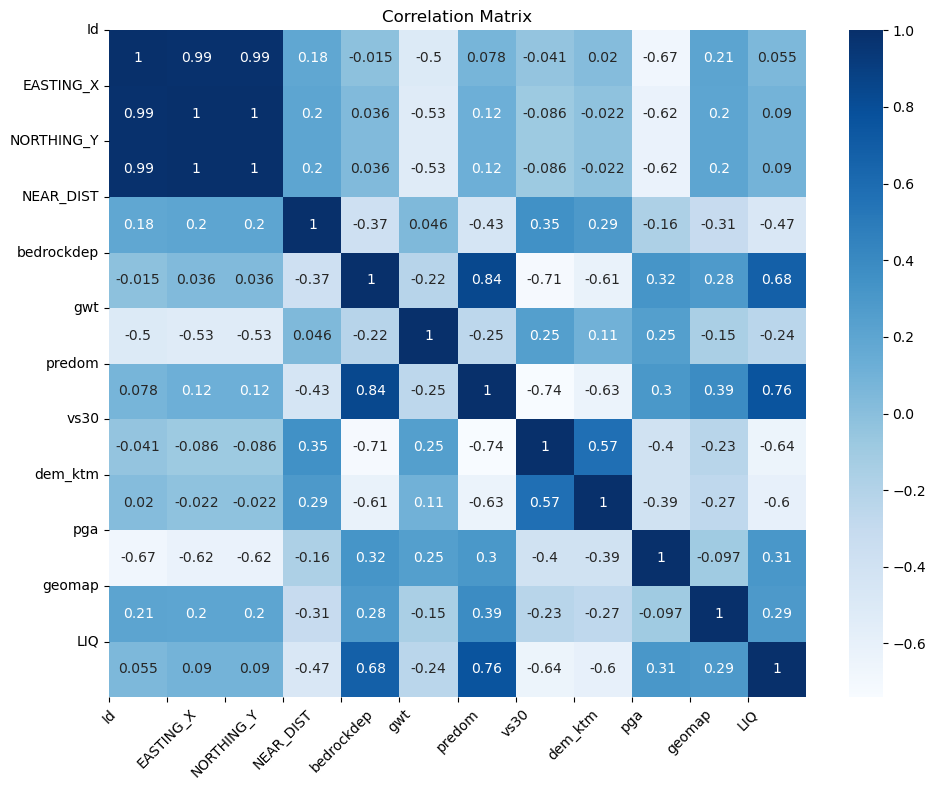

Variance Inflation Factor (VIF):
        VIF    features
0  2.562781   NEAR_DIST
1  8.565858  bedrockdep
2  8.368899        vs30
3  9.289309      predom
4  5.154271         pga
5  6.147300      geomap
Epoch 1, Loss: 0.5468145598625315
Epoch 2, Loss: 0.3607283414437853
Epoch 3, Loss: 0.31227403365332507
Epoch 4, Loss: 0.3000484476315564
Epoch 5, Loss: 0.2930539507290413
Epoch 6, Loss: 0.29351408317171296
Epoch 7, Loss: 0.28947689718213576
Epoch 8, Loss: 0.2877265705630697
Epoch 9, Loss: 0.2954380188522668
Epoch 10, Loss: 0.2772988309634143
Epoch 11, Loss: 0.27960124637546213
Epoch 12, Loss: 0.2748738008326498
Epoch 13, Loss: 0.2743834670761536
Epoch 14, Loss: 0.28172283722408886
Epoch 15, Loss: 0.2765371683856537
Epoch 16, Loss: 0.2695069644471695
Epoch 17, Loss: 0.27543453075762453
Epoch 18, Loss: 0.2689587405786432
Epoch 19, Loss: 0.2728877188316707
Epoch 20, Loss: 0.26872264593839645
Epoch 21, Loss: 0.2764703835649737
Epoch 22, Loss: 0.2841015648225258
Epoch 23, Loss: 0.2707739156381

In [8]:
### RUN FOR HYPERTUNING OF THE MODEL ###
## MINIMUM ETA = 30 MINUTES ##


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set a random seed for reproducibility
torch.manual_seed(36)
np.random.seed(36)

# Load the dataset
data = pd.read_csv("C:\\Users\\LE\\Downloads\\THESIS\\Program\\CSV\\GRID_LABEL_KTMBASIN_1KM_Classify.csv")

# Calculate correlation of the dataset
correlation_matrix = data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Draw heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
#plt.imshow(correlation_matrix, interpolation='nearest')
plt.title("Correlation Matrix")
#plt.colorbar()
tick_marks = [i for i in range(len(data.columns))]
plt.xticks(tick_marks, data.columns, rotation=45)
plt.yticks(tick_marks, data.columns)
plt.tight_layout()
plt.show()


# Preprocess the data
X = data[["NEAR_DIST", "bedrockdep", "vs30", "predom", "pga", "geomap"]]
y = data["LIQ"]

# Calculate VIF
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
print("Variance Inflation Factor (VIF):")
print(vif)

# Create a custom dataset class
class LiquefactionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X.iloc[idx, :].values
        y = self.y.iloc[idx]
        return {
            'x': torch.tensor(x, dtype=torch.float),
            'y': torch.tensor(y, dtype=torch.long)
        }

# Create data loaders

max_depth = 10  # maximum depth of the decision tree
n_estimators = 100  # number of decision trees in the ensemble
random_state = 36  # random state for reproducibility
test_size = 0.3  # test size for testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) 
 
dataset_train = LiquefactionDataset(X_train, y_train) 
dataset_test = LiquefactionDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False)

# Define the ANN model
class ANNModel(nn.Module):
    def __init__(self, hidden_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(6, hidden_size)  # input layer (8) -> hidden layer (128)
        self.fc2 = nn.Linear(hidden_size, 64)  # hidden layer (128) -> hidden layer (64)
        self.fc3 = nn.Linear(64, 2)  # hidden layer (64) -> output layer (2)

    def forward(self, x):
        batch_size = x.size(0)  # get the batch size
        x = x.view(batch_size, 6)  # reshape the input tensor
        x = torch.relu(self.fc1(x))  # activation function for hidden layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Define the hyperparameter space
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'num_epochs': [50, 100, 200],
    'hidden_size': [64, 128, 256]
}

# Perform grid search
grid_search_results = []
for learning_rate in param_grid['learning_rate']:
    for batch_size in param_grid['batch_size']:
        for num_epochs in param_grid['num_epochs']:
            for hidden_size in param_grid['hidden_size']:
                # Initialize the model, dataset, and data loader
                model = ANNModel(hidden_size)
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                model.to(device)
                dataset_train = LiquefactionDataset(X_train, y_train)
                dataset_test = LiquefactionDataset(X_test, y_test)
                train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=False)
                test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False)

                # Initialize the optimizer and criterion
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                criterion = nn.CrossEntropyLoss()

                # Train the model
                for epoch in range(num_epochs):
                    train_loss = 0
                    for batch in train_loader:
                        inputs, labels = batch['x'], batch['y']
                        inputs, labels = inputs.to(device), labels.to(device)
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        train_loss += loss.item()
                    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader)}')

                # Evaluate the model
                model.eval()
                test_loss = 0
                correct = 0
                y_pred_probs = []
                y_true = []
                with torch.no_grad():
                    for batch in test_loader:
                        inputs, labels = batch['x'], batch['y']
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        test_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        correct += (predicted == labels).sum().item()
                        y_pred_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
                        y_true.extend(labels.cpu().numpy())

                accuracy = correct / len(test_loader.dataset)
                print(f'Test Accuracy: {accuracy:.3f}')

                # Calculate precision, recall, F1-score
                y_pred = np.array(y_pred_probs) >= 0.5
                y_true = np.array(y_true)
                precision = precision_score(y_true, y_pred)
                recall = recall_score(y_true, y_pred)
                f1 = f1_score(y_true, y_pred)
                print(f'Precision: {precision:.3f}')
                print(f'Recall: {recall:.3f}')
                print(f'F1-score: {f1:.3f}')

                # Calculate AUROC
                auroc = roc_auc_score(y_true, y_pred_probs)
                print(f'AUROC: {auroc:.3f}')

                # Calculate Kappa score
                kappa = cohen_kappa_score(y_true, y_pred)
                print(f'Cohen Kappa Score: {kappa:.3f}')

                # Calculate confusion matrix
                conf_mat = torch.zeros(2, 2)
                with torch.no_grad():
                    for batch in test_loader:
                        inputs, labels = batch['x'], batch['y']
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        _, predicted = torch.max(outputs, 1)
                        for t, p in zip(labels, predicted):
                            conf_mat[t, p] += 1

                print("Confusion Matrix:")
                print(conf_mat)

                # Calculate true positive rate, false positive rate, true negative rate, false negative rate
                tn, fp, fn, tp = conf_mat.ravel()
                tpr = tp / (tp + fn)  # True positive rate
                fpr = fp / (fp + tn)  # False positive rate
                tnr = tn / (tn + fp)  # True negative rate
                fnr = fn / (fn + tp)  # False negative rate

                print(f"True Positive Rate: {tpr:.3f}")
                print(f"False Positive Rate: {fpr:.3f}")
                print(f"True Negative Rate: {tnr:.3f}")
                print(f"False Negative Rate: {fnr:.3f}")

                # Append the result to the list
                grid_search_results.append({
                    'learning_rate': learning_rate,
                    'batch_size': batch_size,
                    'num_epochs': num_epochs,
                    'hidden_size': hidden_size,
                    'test_accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'auroc': auroc,
                    'kappa': kappa,
                    'tpr': tpr,
                    'fpr': fpr,
                    'tnr': tnr,
                    'fnr': fnr
                })

# Print the best result
best_result = max(grid_search_results, key=lambda x: x['test_accuracy'])
print("Best hyperparameters:")
print("Learning rate:", best_result['learning_rate'])
print("Batch size:", best_result['batch_size'])
print("Number of epochs:", best_result['num_epochs'])
print("Hidden size:", best_result['hidden_size'])
print("Test accuracy:", best_result['test_accuracy'])
print("Precision:", best_result['precision'])
print("Recall:", best_result['recall'])
print("F1-score:", best_result['f1_score'])
print("AUROC:", best_result['auroc'])
print("Kappa:", best_result['kappa'])
print("True Positive Rate:", best_result['tpr'])
print("False Positive Rate:", best_result['fpr'])
print("True Negative Rate:", best_result['tnr'])
print("False Negative Rate:", best_result['fnr'])